## Main projetct

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In this notebook, you will follow our approach in our project aiming at detecting the wearing of masks.
You can follow all the notebook on Google Colab, but won't be able to try the model using your own webcam.


---


First, the challenge of our project was to make our own dataset, that means to create data and then label it to train our model.

In a second time, we used Yolov5 to use one of their models to be able to train our own model for classification.

At the end you will be able to try the models out and see how it works, either on pre-recorded videos or if you're executing the model on your local machine, in real-time with your webcam (which is quite fun).


---


Note that if you want to fully execute this notebook on your local machine you will need a CUDA enabled NVIDIA GPU !

First, you have to clone the Yolov5 folders from the Ultralytics GitHub so we can use their training algorithm and their custom models

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone

Cloning into 'yolov5'...
remote: Enumerating objects: 10876, done.
remote: Total 10876 (delta 0), reused 0 (delta 0), pack-reused 10876
Receiving objects: 100% (10876/10876), 10.98 MiB | 23.27 MiB/s, done.
Resolving deltas: 100% (7515/7515), done.


Now you will need to go to the yolov5 folder and install the requirements.txt to make sure you have all the Python libraries you need to train and detect with Yolov5

In [ ]:
%cd yolov5
!pip install -r requirements.txt  # install
%cd ..

/content/yolov5
     |████████████████████████████████| 596 kB 5.4 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
/content


As we will download data from other websites, make sure you have wget installed, this way you will be able to download the data we will use later on

In [ ]:
!pip3 install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=0d9c9e6f040db10ab163689bebef6896fbaeb41729ed6fe384721465c33f30c4
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


We made our own dataset using our own pictures and videos, labelising it with [Supervise.ly](https://), that's from this website that we will download our dataset in a Tar file.


---


If you want more information on the process of labelising data and how we managed to use the website in cooperation, feel free to ask us on our GitHub.
However most of the relevant information can be found directly on the website.

In [ ]:
import wget

!mkdir data
%cd data

link = 'https://app.supervise.ly/h5un6l2bnaz1vj8a9qgms4-public/teams_storage/46385/p/b/Wu/s9B7kTZ7aYk4xFXx5i67t91dtuPtlbW45xiQaDF0tLpQKkWsWEdZOSdyMFHioT5UuyOfTLdEdtgQAH7yVF82vFedartZsMtztE07AHscZIGjBzuOlJVYXVlmwc4L.tar'

file_name = wget.download(link)

/content/data


Here we want to get the name of the archive as it can change over time, depending on which batch of data we provided in the link above.

In [ ]:
#get the name of the archive
import glob

targetPattern = r"*.tar"
file_name = glob.glob(targetPattern)[0]

Now we can extract all the data from the Tar file that the website provided us

In [ ]:
# get data and extract

import tarfile

tar = tarfile.open(file_name)
tar.extractall()
tar.close()

Remove the Tar file to clean up a bit our environment

In [ ]:
#remove tarfile
import os

os.remove(file_name)

%cd ..

/content


Even though the website provides us with the data and the labels that we worked on in a Yolov5 format, the form isn't right.

In fact, to make it work we want at least to have a train and validation set, so the training can be done properly, and a test set wouldn't be a bad idea to if we want to test our model later on.


---


So now we will want to split the data, to do that, let's first import some libraries that we will need in our function.

In [ ]:
#here we will split the data into train validation and test folders

import shutil, os
import glob
import math
from PIL import Image
from random import shuffle
import tkinter, tkinter.constants, tkinter.filedialog
import yaml

To reference the dataset when we will train our model, we will need a YAML file, that will indicate the number of classes, their names and the path of the training and validation sets folders.

Note that if you are working a local machine you will need to change the paths as they are made to work in Colab on the first place.

In [ ]:
#this will make the yaml file we need to train yolov5

def make_yaml(src_path,dest_path):
    with open(src_path + '/data_config.yaml') as file: #open the document provided by the website
        documents = yaml.full_load(file)

    for item, doc in documents.items(): #get the data from this doc
        if (item == "names"):
            item_names = doc
        if (item == "nc"):
            item_nc = doc
    
    data_file = open(dest_path + "/data.yaml","w") #make the new YAML file
    lines = ["train: /content/data_ready/" + "/train/images\n",
    "val: /content/data_ready/" + "/valid/images\n",
    "test: /content/data_ready/" + "/test/images\n","\n",
    "nc: {}\n".format(item_nc),
    "names: {}".format(item_names)]
    data_file.writelines(lines) #write the lines we need for our training

Then we will need to split the pictures and labels in different sets, to do that we will use this function.

In [ ]:
def split_pictures(src_path, dest_path,coef_train,coef_valid,coef_test):

    #shuffle files to get a list
    files_temp = glob.glob(src_path + "/images/train/" + "*.jpg")
    files = []

    #get rid of the extension to shuffle both folders with the same names
    for i in range(len(files_temp)):
        name_temp = files_temp[i]
        name_temp_2 = name_temp[:-4]
        name = name_temp_2[len(src_path + "/images/train/"):]
        files.append(name)

    shuffle(files)

    files_images = []
    files_labels = []
    files_images_path = src_path + "/images/train/"
    files_labels_path = src_path + "/labels/train/"

    for i in range(len(files)):
        name_temp = files[i]
        name_images = files_images_path + name_temp + ".jpg"
        name_labels = files_labels_path + name_temp + ".txt"
        files_images.append(name_images)
        files_labels.append(name_labels)

    #get the number of images for the different directories
    nb_files = len(glob.glob(src_path + "/images/train/" + "*.jpg"))
    nb_train = round(coef_train * nb_files)
    nb_valid = round(coef_valid * nb_files)
    nb_test = round(coef_test * nb_files)

    if ((nb_train + nb_valid + nb_test) > nb_files):
        nb_test -= 1
    elif ((nb_train + nb_valid + nb_test) < nb_files):
        nb_test += 1

    print("Number of files : ",nb_files)
    print("Number of train files : ",nb_train)
    print("Number of valid files : ",nb_valid)
    print("Number of test files : ",nb_test)

    #create directories
    dest_train = dest_path + "/train"
    dest_valid = dest_path + "/valid"
    dest_test = dest_path + "/test"

    try:
        os.mkdir(dest_path)
    except OSError:
        print ("Creation of the directory %s failed or it already exists" % dest_path)

    try:
        os.mkdir(dest_train)
    except OSError:
        print ("Creation of the directory %s failed or it already exists" % dest_train)

    try:
        os.mkdir(dest_valid)
    except OSError:
        print ("Creation of the directory %s failed or it already exists" % dest_valid)

    try:
        os.mkdir(dest_test)
    except OSError:
        print ("Creation of the directory %s failed or it already exists" % dest_test)

    #create image and labels directories

    dest_train_images = dest_train + "/images"
    dest_train_labels = dest_train + "/labels"
    dest_valid_images = dest_valid + "/images"
    dest_valid_labels = dest_valid + "/labels"
    dest_test_images = dest_test + "/images"
    dest_test_labels = dest_test + "/labels"

    try:
        os.mkdir(dest_train_images)
    except OSError:
        print ("Creation of the directory %s failed or it already exists" % dest_train_images)

    try:
        os.mkdir(dest_train_labels)
    except OSError:
        print ("Creation of the directory %s failed or it already exists" % dest_train_labels)

    try:
        os.mkdir(dest_valid_images)
    except OSError:
        print ("Creation of the directory %s failed or it already exists" % dest_valid_images)

    try:
        os.mkdir(dest_valid_labels)
    except OSError:
        print ("Creation of the directory %s failed or it already exists" % dest_valid_labels)

    try:
        os.mkdir(dest_test_images)
    except OSError:
        print ("Creation of the directory %s failed or it already exists" % dest_test_images)

    try:
        os.mkdir(dest_test_labels)
    except OSError:
        print ("Creation of the directory %s failed or it already exists" % dest_test_labels)

    #put the images in the directories
    for i in range(len(files_images)):
        if i < nb_train:
            if not os.path.exists(dest_train_images + '/' + os.path.basename(files_images[i])): #manage file duplicates
                shutil.move(files_images[i], dest_train_images)
        elif i < nb_valid + nb_train:
            if not os.path.exists(dest_valid_images + '/' + os.path.basename(files_images[i])):
                shutil.move(files_images[i], dest_valid_images)
        else:
            if not os.path.exists(dest_test_images + '/' + os.path.basename(files_images[i])):
                shutil.move(files_images[i], dest_test_images)

    #put the labels in the directories
    for i in range(len(files_labels)):
        if i < nb_train:
            if not os.path.exists(dest_train_labels + '/' + os.path.basename(files_labels[i])):
                shutil.move(files_labels[i], dest_train_labels)
        elif i < nb_valid + nb_train:
            if not os.path.exists(dest_valid_labels + '/' + os.path.basename(files_labels[i])):
                shutil.move(files_labels[i], dest_valid_labels)
        else:
            if not os.path.exists(dest_test_labels + '/' + os.path.basename(files_labels[i])):
                shutil.move(files_labels[i], dest_test_labels)

    #make yaml
    make_yaml(src_path,dest_path)

Now that our function is ready, let's use it ! 
You can change the coefficients if you feel like you want to, but usual trainings take 70% for the training, 20% for the validation and 10% for the test.

In [ ]:
#make sure you keep the sum of the coefficients at 1
#usual training takes 0.7, 0.2, 0.1 for train, valid, test

#paths for the folders, can be replaced by where you put the data or where you want to put the data processed

split_pictures("/content/data","/content/data_ready",0.7,0.2,0.1)

Number of files :  530
Number of train files :  371
Number of valid files :  106
Number of test files :  53


Just some cleaning for the old folders

In [ ]:
#delete data directory
!rm -r data

Make sure to use the GPU for the training otherwise it will take forever even for a few epochs
If you're using colab go to execute > execution type > use GPU


---


Now we can finaly train our model !

In [ ]:
#now we will want to train our own model
#to make our model stronger, we will use transfer learning later on, but for now we only have a simple train to begin with

%cd yolov5

!python3 train.py --data ../data_ready/data.yaml --cfg yolov5s.yaml --batch-size 15 --epochs 5


[Errno 2] No such file or directory: 'yolov5'
/content/yolov5
train: weights=yolov5s.pt, cfg=yolov5s.yaml, data=../data_ready/data.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=5, batch_size=15, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
Traceback (most recent call last):
  File "/usr/lib/python3.7/subprocess.py", line 964, in communicate
    stdout, stderr = self._communicate(input, endtime, timeout)
  File "/usr/lib/python3.7/subprocess.py", line 1715, in _communicate
    ready = selector.select(timeout)
  File "/usr/lib/python3.7/selectors.py", line 415, in select
    fd_event_lis

To have a first overview of our training, we can display the confusion matrix, the precision and the recall to have a first impression of the results

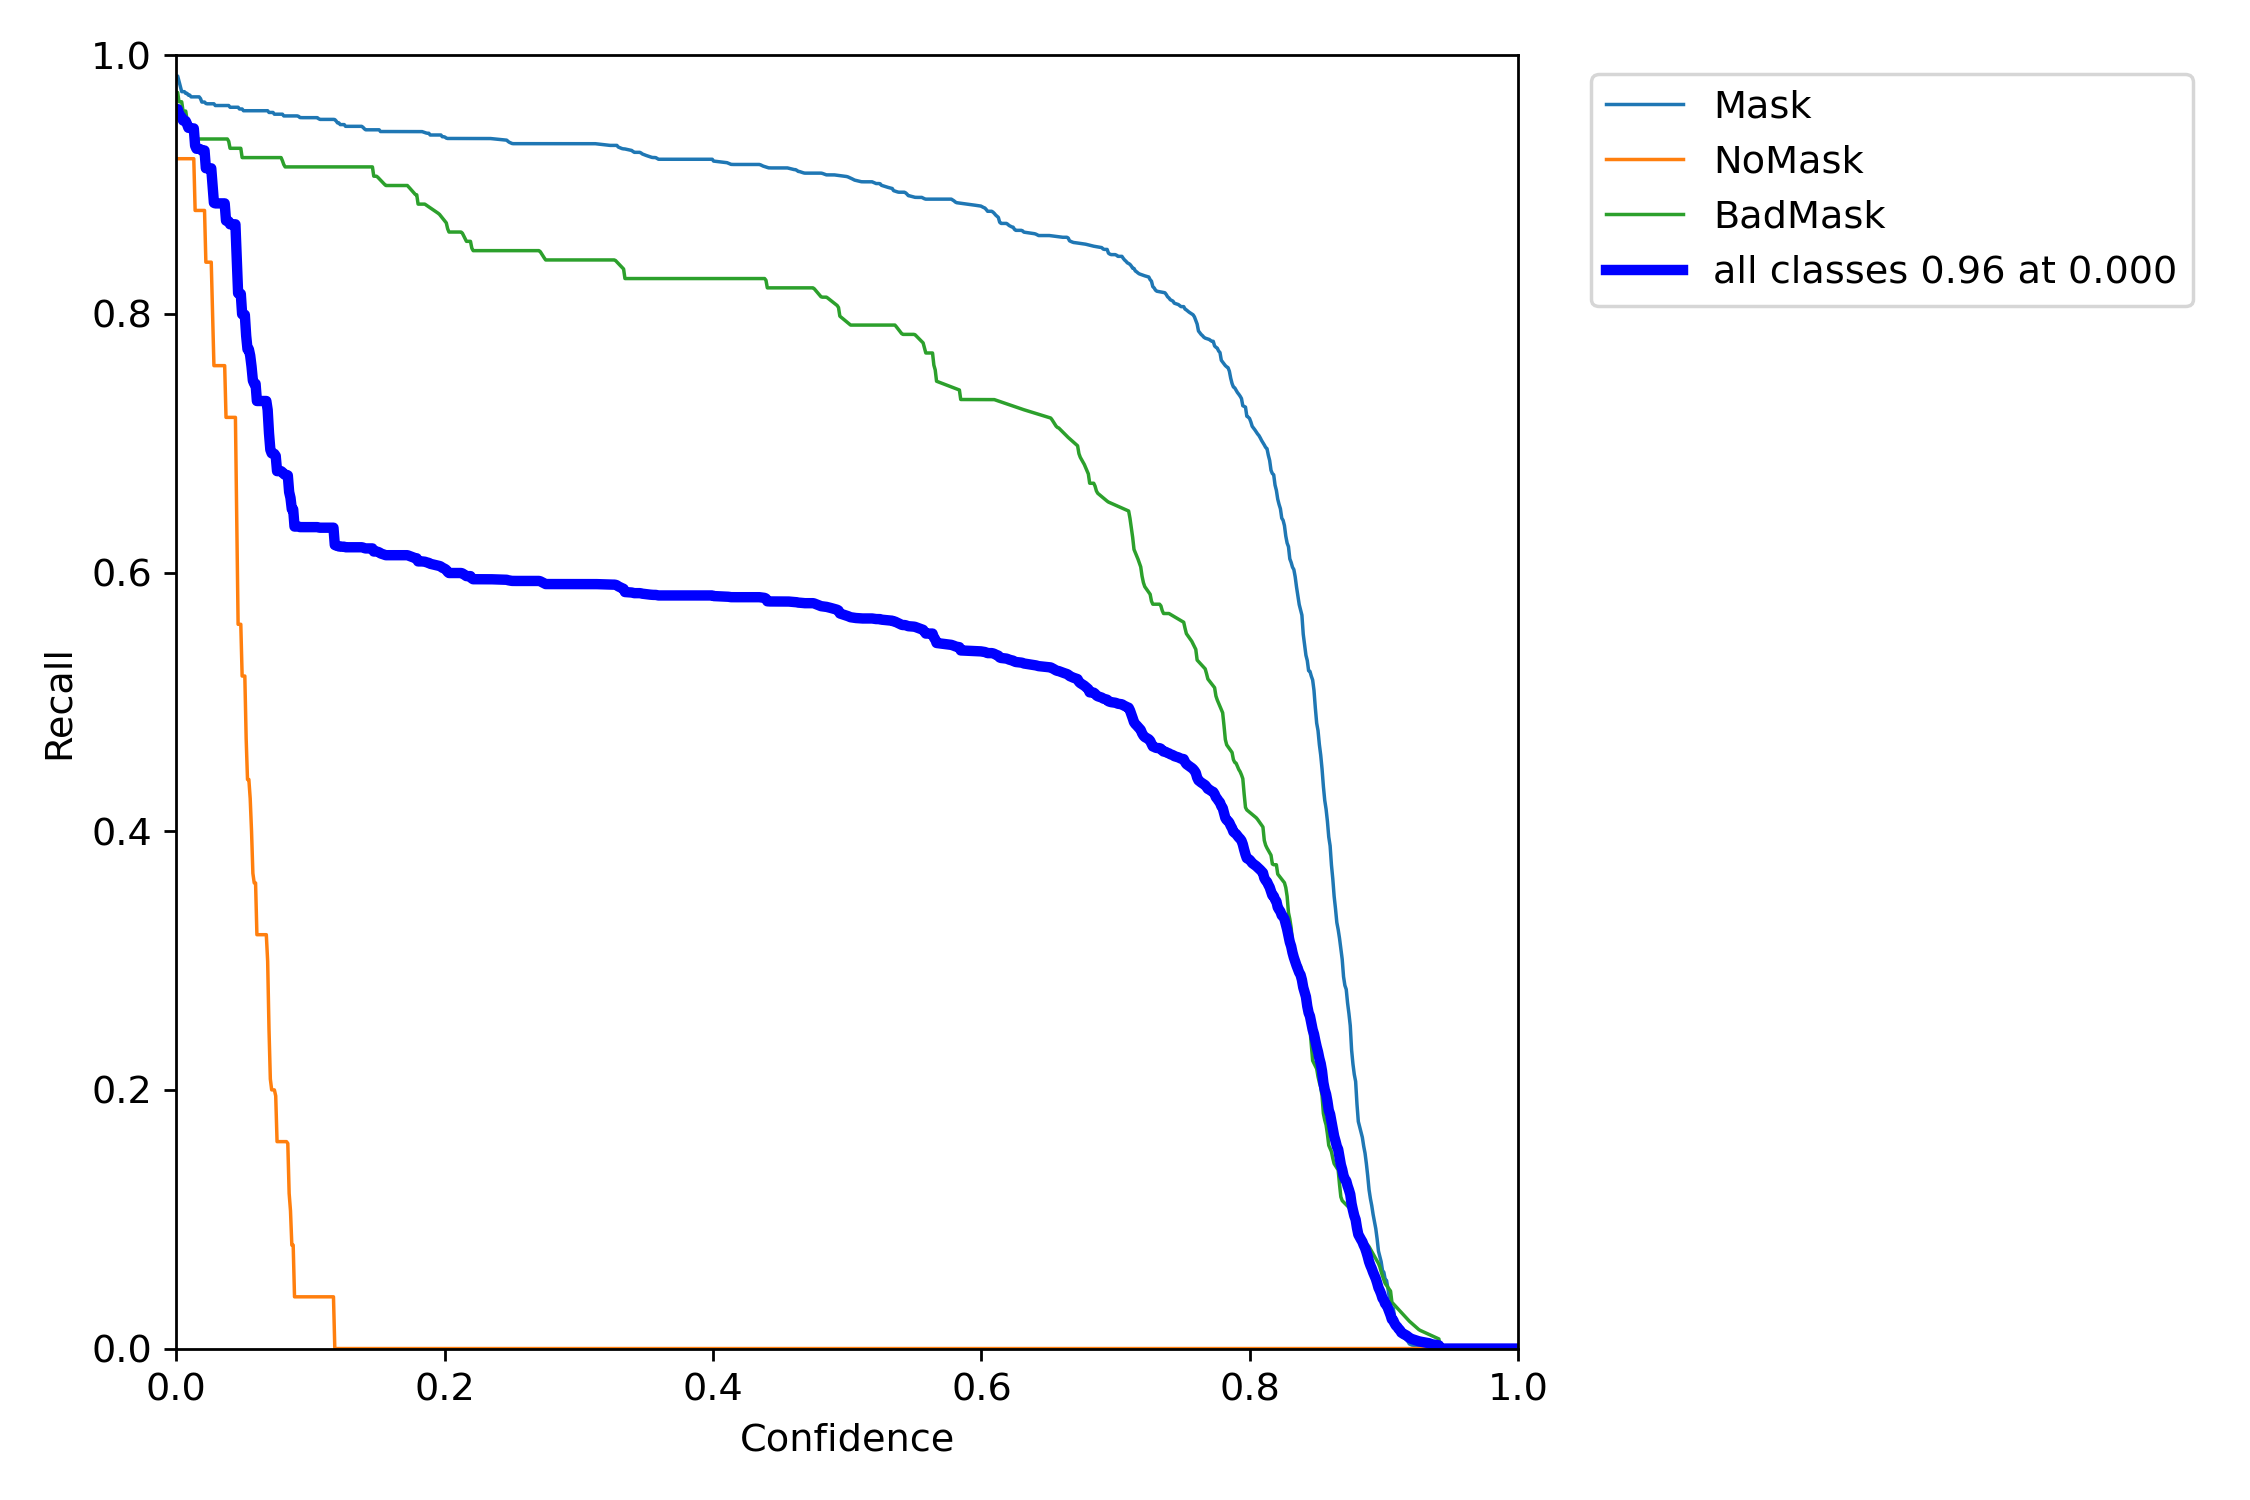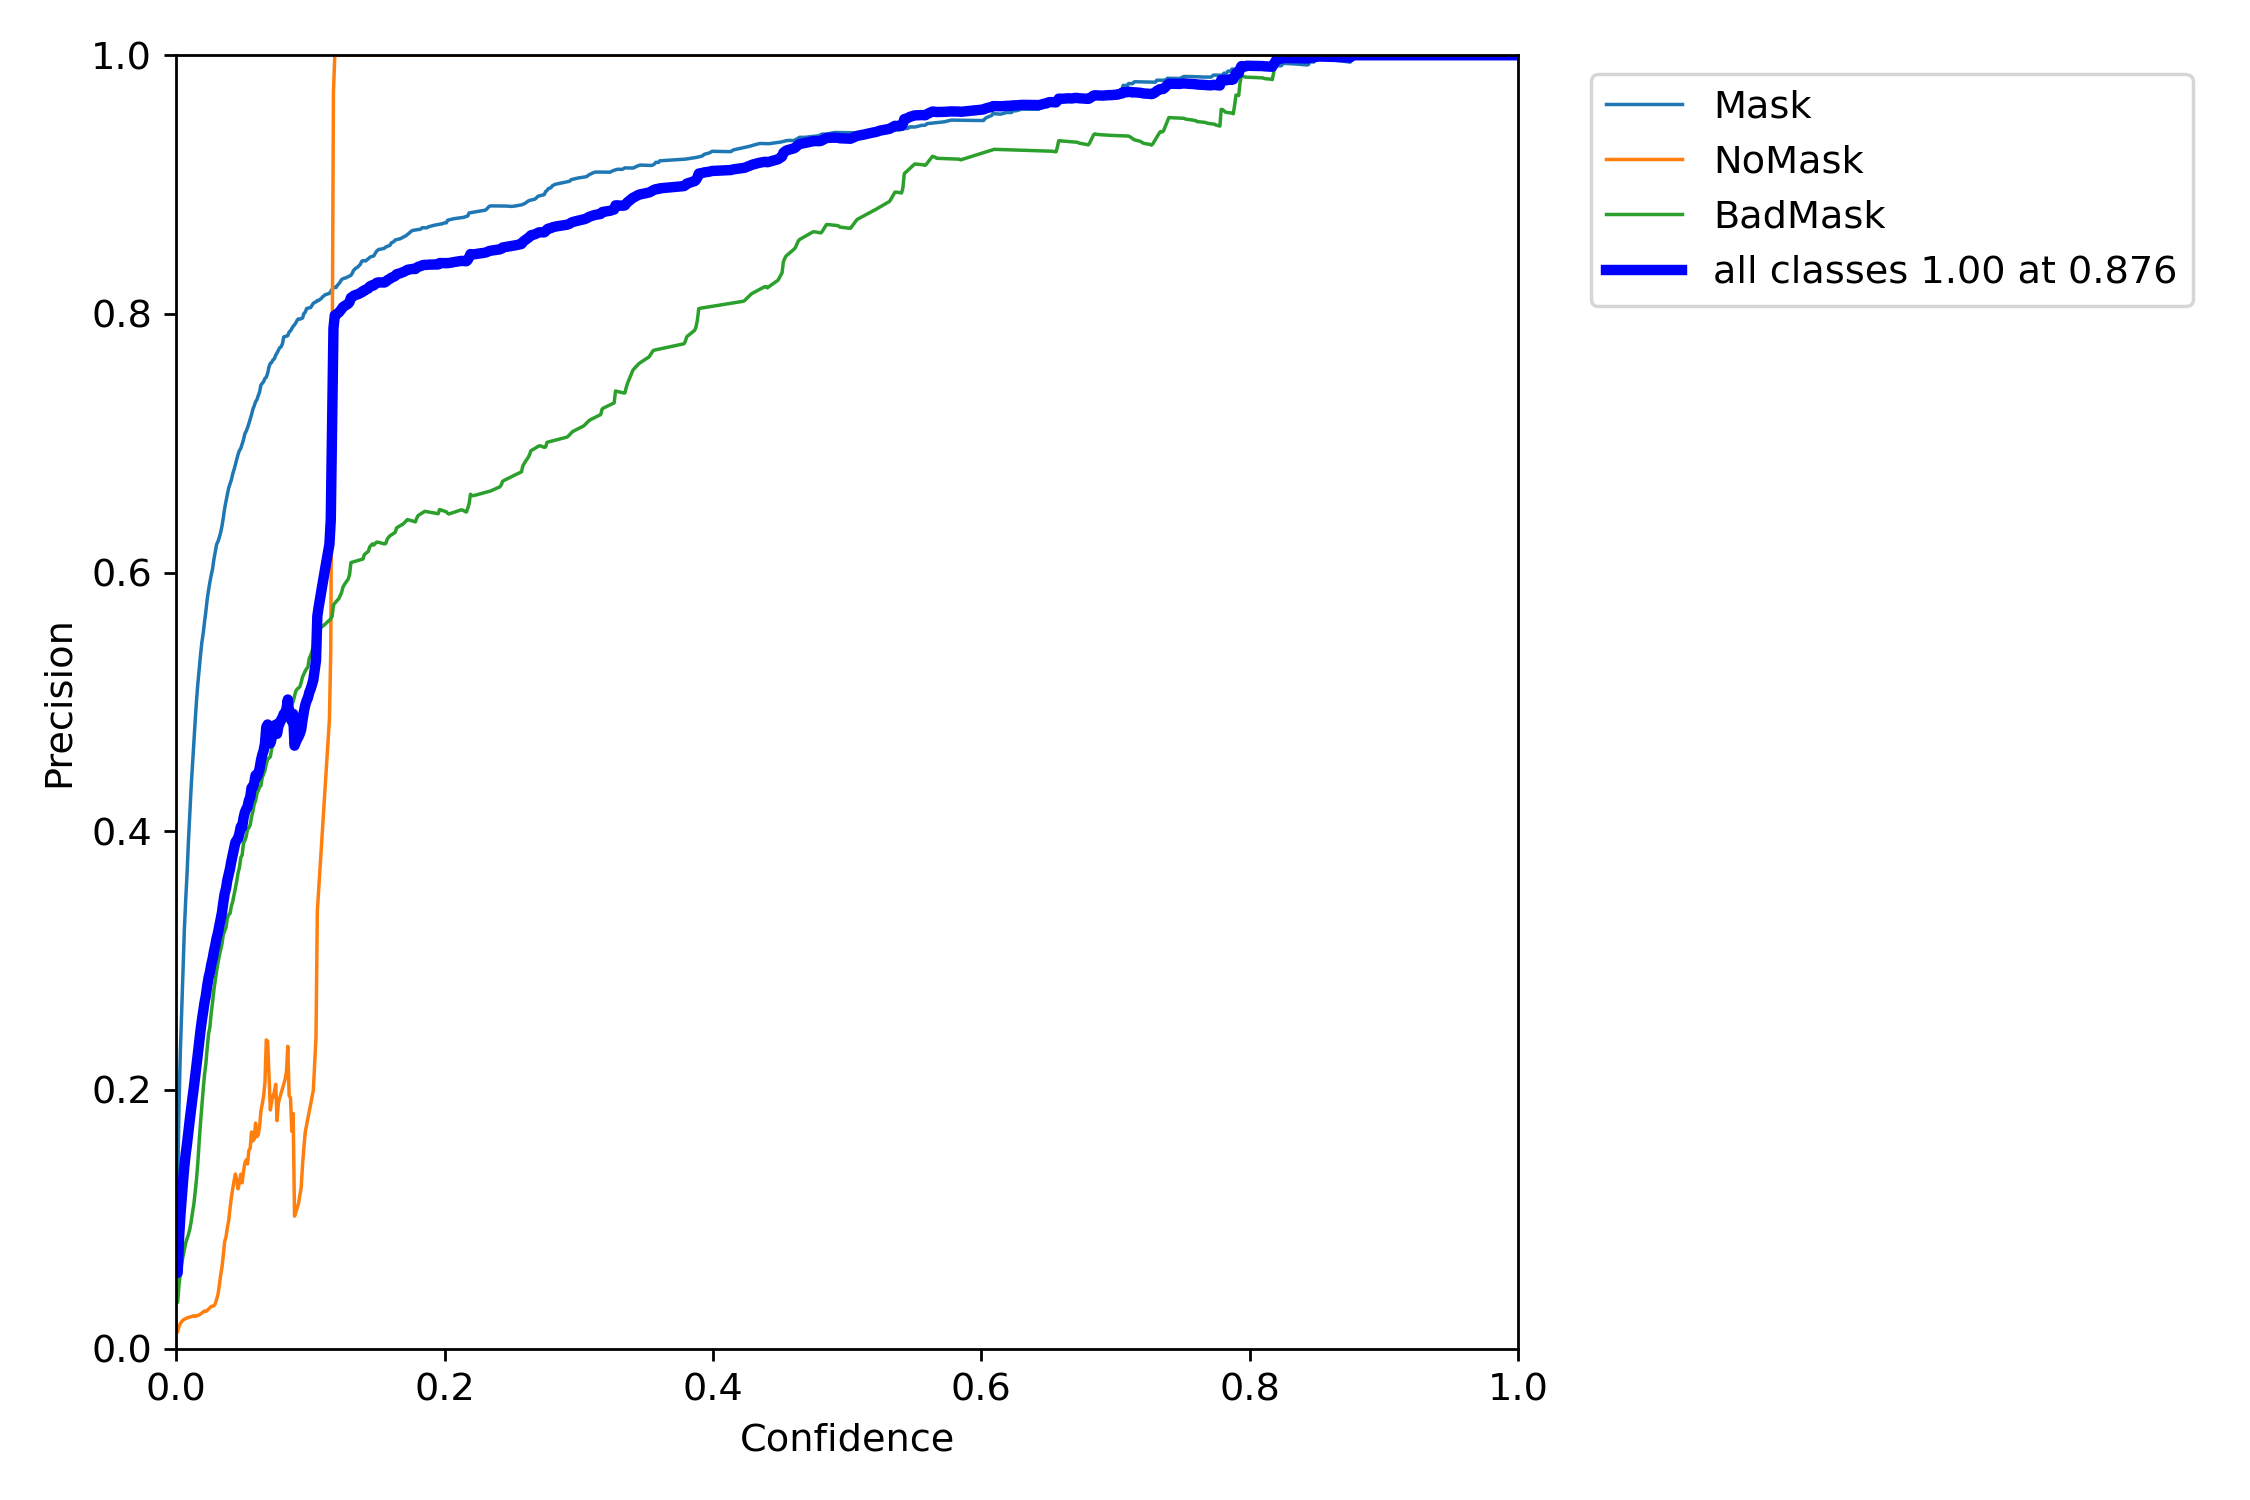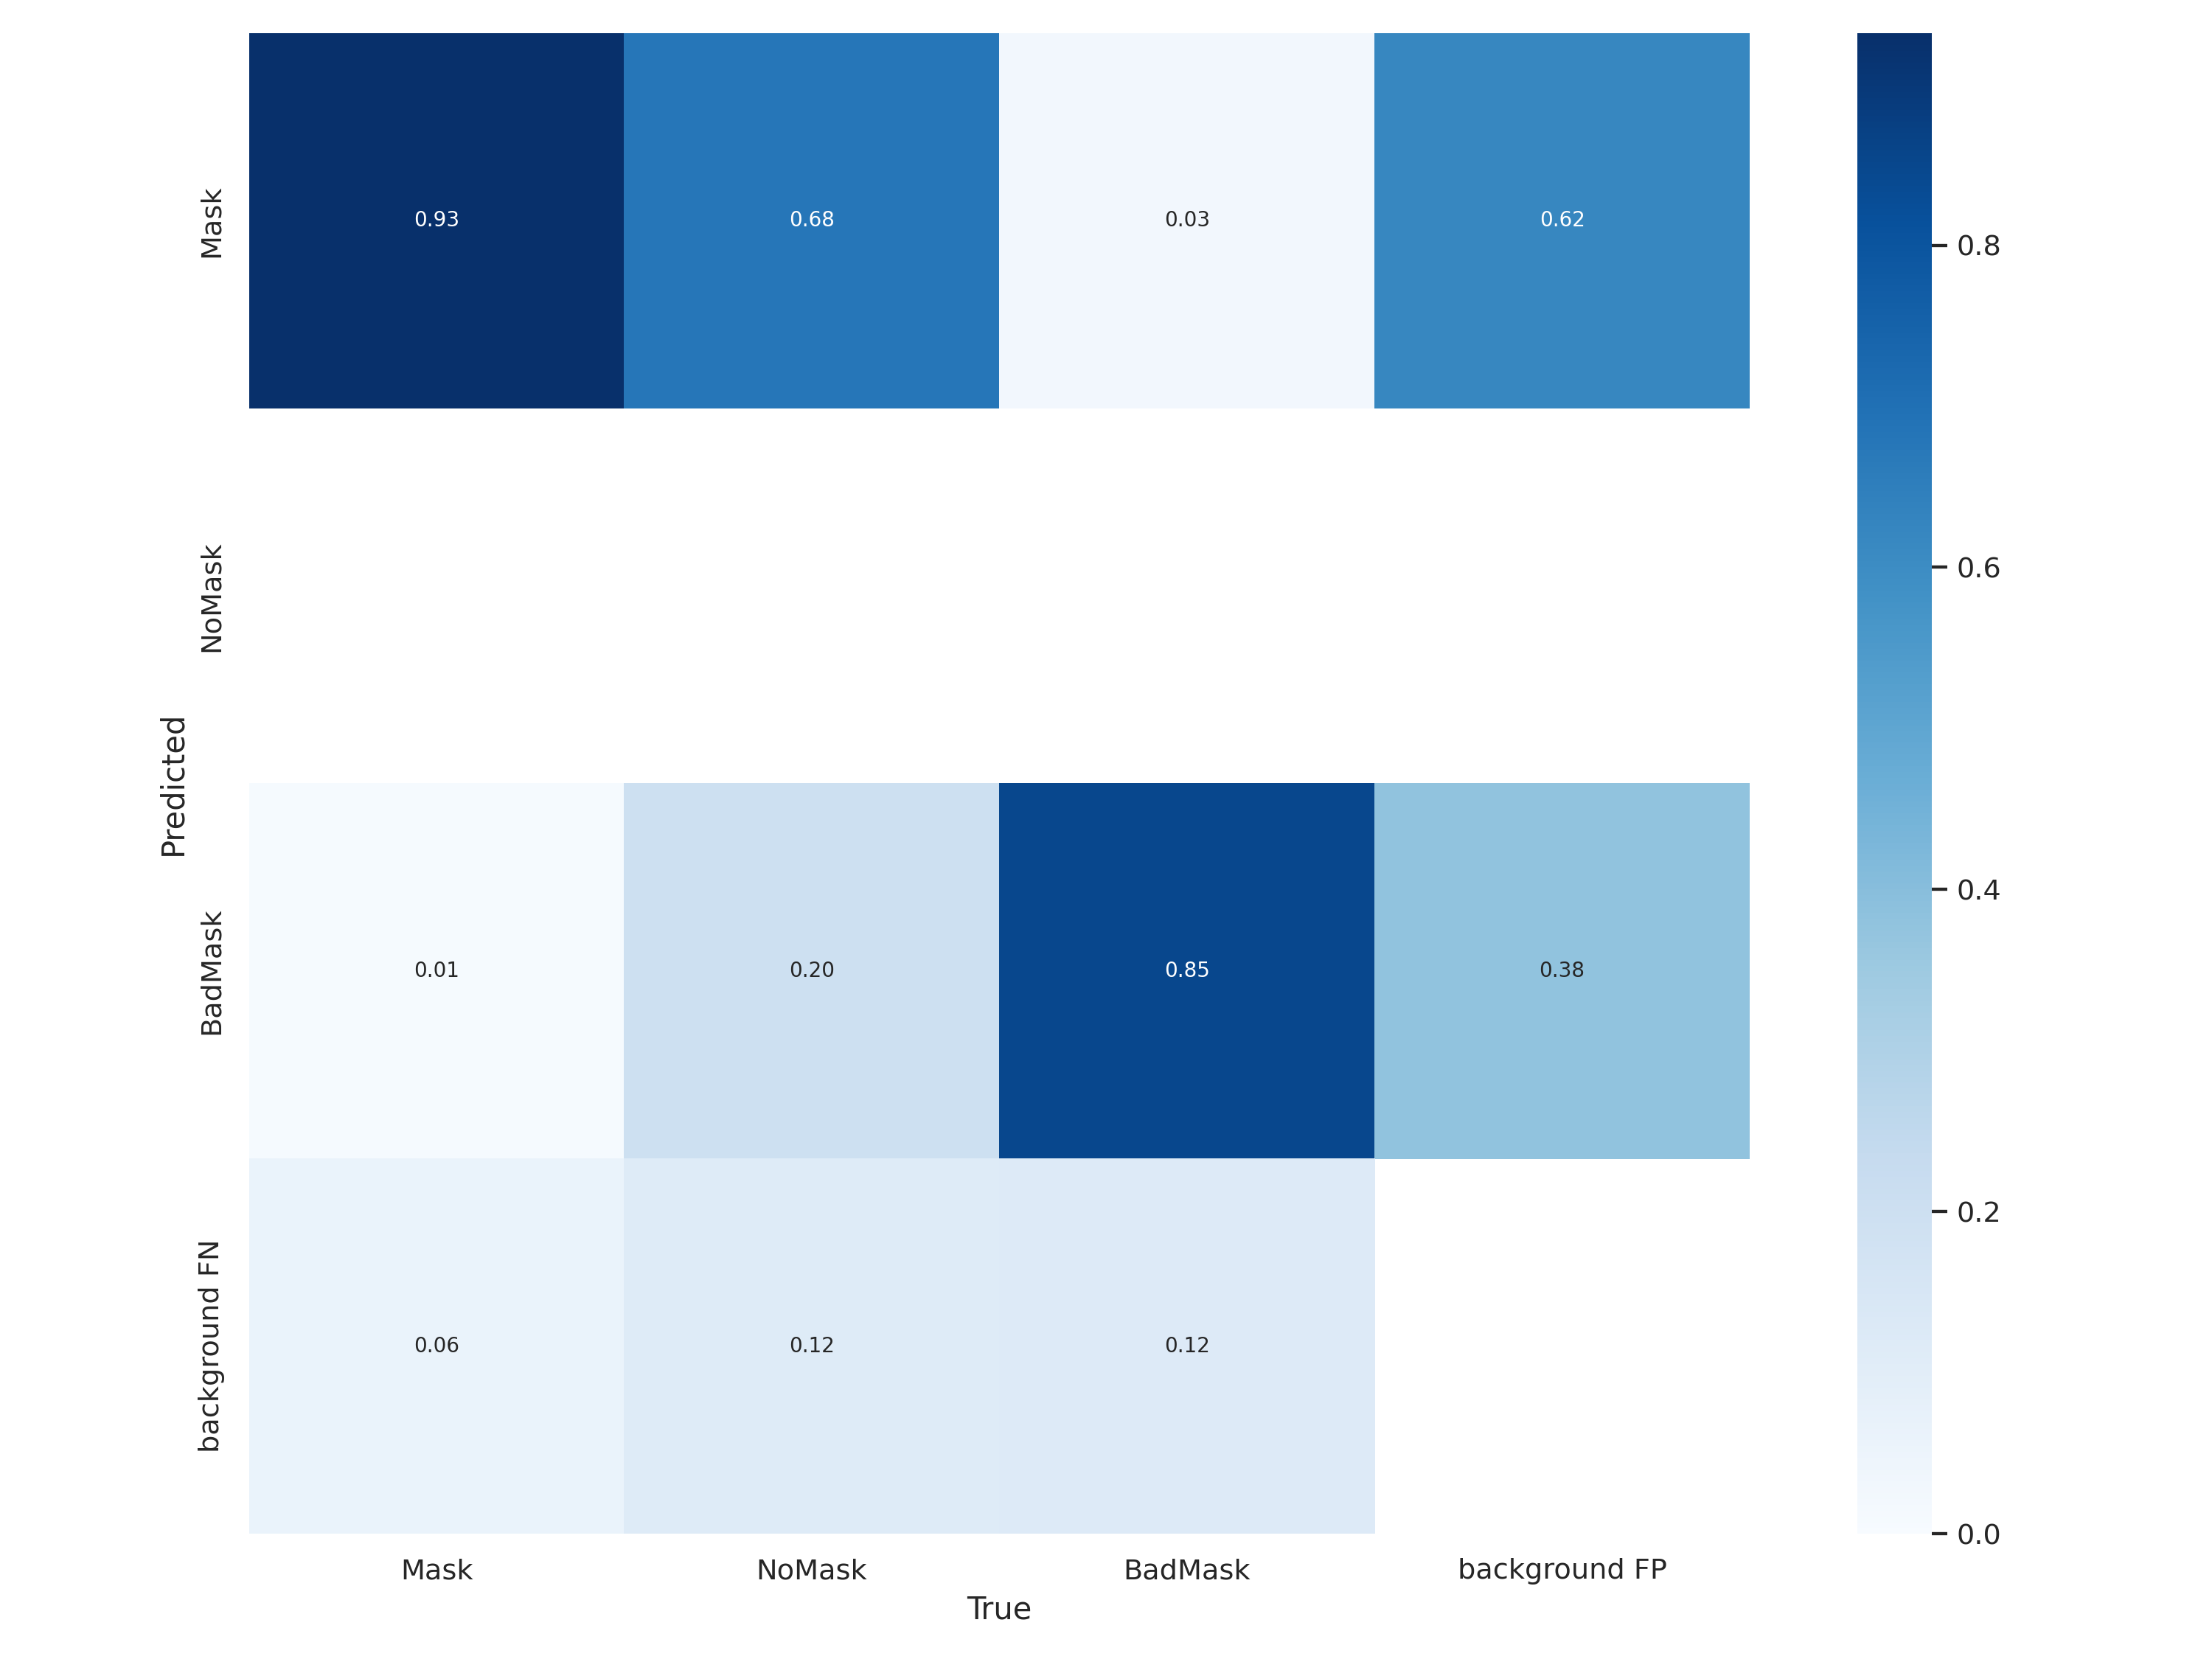


---
From this matrix confusion we can say that our model has successfully 
learned how to recognise whether a person wear a mask or not (chirurgical mask precisely). However we can see that it struggles to identify when the mask is not wore correctly. 



*   This is not supprising considering the data on which the model was trained. There is less annotated files with the class "BadMask". To improve that we could run a data augmentation process or just acquire new data from this class
*   Another  bias is the ethnicity. Indeed our algorithm was trained mainly on images representing white people, it has not sufficiantly learn to recognise people from other ethnic
*   To go further it could be interesting to improve the dataset with different type of mask








Now you can try some detection from the model that we just made together !
Here we will download some videos we put in a drive so you can try it on them but you can also try to import your own pictures or videos yourself and see how it does

Let's import a quick video to test our model

We will use the data in this drive, just import it and you'll be good to go

https://drive.google.com/drive/folders/1_DcVjQZEG6rUq86nFdLey4144CZlNo9R?usp=sharing


And now launch the detection on the data you chose

In [ ]:
#now let's try a quick detect to see how this first model works on a test folder with prerecorded videos

!python3 detect.py --source /content/drive/MyDrive/FaceMaskRecognition_data/test_videos --weights /content/yolov5/runs/train/exp/weights/best.pt

detect: weights=['/content/yolov5/runs/train/exp/weights/best.pt'], source=/content/drive/MyDrive/FaceMaskRecognition_data/test_videos, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-255-gca0a007 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

Fusing layers... 
Model Summary: 213 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
video 1/3 (1/321) /content/drive/MyDrive/FaceMaskRecognition_data/test_videos/Video2.mp4: 384x640 2 masks, Done. (0.038s)
video 1/3 (2/321) /content/drive/MyDrive/FaceMaskRecognition_data/test_videos/Video2.mp4: 384x640 3 masks, Done. (0.027s)
video 1/3 (3/321) /content/drive/MyDrive/FaceMaskRecognition_data/test_vi

You can go in the folder that the scripts indicates at the end of the execution and see for yourself the results !
Usualy you can just go in the yolov5/runs/detect/exp?? and you'll find your detection

In [ ]:
#you can also try out the model with your own webcam if you want, just note you have to be working in a local environement for it to work properly

!python3 detect.py --source 0 --weights /content/yolov5/runs/train/exp2/weights/best.pt

Not so good? A bit disapointed? You thought it was too easy to be true?
You were right.
As you can see, even with only a few trainings you already can have quite promising results, but for it to have a better detection you have to train with a lot more data and epochs.
The problem is that finding data and waiting for the model to train takes a lot of time, that's why we made the training for you so you won't have to suffer the pain we endured waiting hours.


---


With that said, you can now download our own pretrained weights and parameters that have been previously trained by our team to fully enjoy this project

If you can't find in your drive, it can be found on this URL : https://github.com/goldentrex/FaceMaskRecognition/blob/main/trains/exp1/weights/best.pt

In [ ]:
#link to download .pt

import wget

%cd /content/
!mkdir weights
%cd weights

link = 'https://github.com/goldentrex/FaceMaskRecognition/blob/main/trains/exp1/weights/best.pt'

file_name = wget.download(link)

###### IMPORTANT NOTE ######

#if you're trying to make a new training using the previous weights, download them first on your local machine and upload them manualy onto colab

#don't ask me why but this wasn't working at all despite the fact that the file was here

#for further information you can consult this thread where I found the solution :

# https://github.com/xinntao/ESRGAN/issues/67

Now you can launch a new detection with the proper weights that we have trained and see the results for yourself !

In [ ]:
#detect avec les nouveaux poids

!python3 detect.py --source /content/drive/MyDrive/FaceMaskRecognition_data/test_videos --weights /content/best.pt

detect: weights=['/content/best.pt'], source=/content/drive/MyDrive/FaceMaskRecognition_data/test_videos, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-255-gca0a007 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

Fusing layers... 
Model Summary: 213 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
video 1/2 (1/188) /content/drive/MyDrive/FaceMaskRecognition_data/test_videos/TestVideo1.mov: 384x640 5 Masks, 2 NoMasks, Done. (0.027s)
video 1/2 (2/188) /content/drive/MyDrive/FaceMaskRecognition_data/test_videos/TestVideo1.mov: 384x640 5 Masks, 3 NoMasks, Done. (0.027s)
video 1/2 (3/188) /content/drive/MyDrive/FaceMaskRecognition_data/test_vi

You can now see the results by yourself !

Results will still be foundable in content>yolov5>runs>detect>your_last_exp

You can skip the all "additional training" if you don't want to see how we used multiple datasets and transfer learning.
Results and thoughts are at the very end

## Additional training

-----------------------
---
Additionnal training :

This is the dataset we used to reinforce our model, the code and the way of transforming the labels to be usable in Yolov5 are below.
If you want to try to train it yourself you can use the code provided here but it will take some time for you to train the model again.

The code below has been borrowed from https://www.kaggle.com/gnldyd/face-mask-detection-yolov5

Here we just copy the data in our environment so we can make proper work on it

In [ ]:
%cp -r '/content/drive/MyDrive/FaceMaskRecognition_data/kaggle_dataset/' '/content/'

In [ ]:
import os

path = '/content/kaggle_dataset/'
annotations_path = path + 'annotations/'
images_path = path + 'images/'

annotations_files = [something for something in os.listdir(annotations_path) if not os.path.isdir(annotations_path + something)]
images_files = [something for something in os.listdir(images_path) if not os.path.isdir(images_path + something)]
annotations_files[:5], images_files[:5]

(['maksssksksss517.xml',
  'maksssksksss661.xml',
  'maksssksksss537.xml',
  'maksssksksss260.xml',
  'maksssksksss773.xml'],
 ['maksssksksss482.png',
  'maksssksksss304.png',
  'maksssksksss510.png',
  'maksssksksss21.png',
  'maksssksksss114.png'])

This will sort by number

In [ ]:
import re

annotations_files.sort(key = lambda e: int(re.sub('[^0-9]', '', e)))
images_files.sort(key = lambda e: int(re.sub('[^0-9]', '', e)))
annotations_files[:5], images_files[:5]

(['maksssksksss0.xml',
  'maksssksksss1.xml',
  'maksssksksss2.xml',
  'maksssksksss3.xml',
  'maksssksksss4.xml'],
 ['maksssksksss0.png',
  'maksssksksss1.png',
  'maksssksksss2.png',
  'maksssksksss3.png',
  'maksssksksss4.png'])

Make the directories

In [ ]:
pwd = !pwd # ['/kaggle/working']
pwd = pwd[0] + '/'

dataset_path = pwd + 'datasets/facemask/'
if not os.path.isdir(dataset_path):
    !mkdir -p {dataset_path}

new_images_path = dataset_path + 'images/'
new_labels_path = dataset_path + 'labels/'

if not os.path.isdir(new_images_path):
    !cp -rf {images_path} {dataset_path}
if not os.path.isdir(new_labels_path):
    !mkdir -p {new_labels_path}
!ls {dataset_path}

images	labels


Make label files

In [ ]:
def get_yolo_format(pic_width, pic_height, x_min, y_min, x_max, y_max):
    x_center = (x_max + x_min) / (2 * pic_width)
    y_center = (y_max + y_min) / (2 * pic_height)
    width = (x_max - x_min) / pic_width
    height = (y_max - y_min) / pic_height
    return x_center, y_center, width, height


In [ ]:
import xml.etree.ElementTree as ET

labels = ['with_mask', 'mask_weared_incorrect', 'without_mask']
infos = [] # used <5. Compare images>

for annotations_file in annotations_files:
    label_file_name = annotations_file.split('.')[0] + '.txt'
    with open(new_labels_path + label_file_name, 'w') as label_file:
        root = ET.parse(annotations_path + annotations_file)
        pic_width = int(root.find('size').findtext('width'))
        pic_height = int(root.find('size').findtext('height'))
        info = [pic_width, pic_height]
        for obj in root.findall('object'):
            box_info = []
            class_name = obj.findtext('name')
            x_min = int(obj.find('bndbox').findtext('xmin'))
            y_min = int(obj.find('bndbox').findtext('ymin'))
            x_max = int(obj.find('bndbox').findtext('xmax'))
            y_max = int(obj.find('bndbox').findtext('ymax'))
            info.append([labels.index(class_name), x_min, y_min, x_max, y_max])
            yolo_format = get_yolo_format(pic_width, pic_height, x_min, y_min, x_max, y_max)
            label_file.write(str(labels.index(class_name)) + ' ' + ' '.join(map(str, yolo_format)) + '\n')
        infos.append(info)
        label_file.flush()

In [ ]:
labels_files = [something for something in os.listdir(new_labels_path) if not os.path.isdir(new_labels_path + something)]
labels_files.sort(key = lambda e: int(re.sub('[^0-9]', '', e)))

Now our new data is available

In [ ]:
!cat {new_labels_path}{labels_files[0]}

2 0.18359375 0.337431693989071 0.05859375 0.10109289617486339
0 0.4013671875 0.3333333333333333 0.080078125 0.12021857923497267
2 0.6689453125 0.3155737704918033 0.068359375 0.13934426229508196


Let's clean a bit by deleting the folder

In [ ]:
!rm -r /content/kaggle_dataset

We now want to create a YAML file to be able to use the split function

In [ ]:
#this will make the yaml file we need to train yolov5

def make_yaml(src_path,dest_path):
    with open(src_path + '/data_config.yaml') as file: #open the document provided by the website
        documents = yaml.full_load(file)

    for item, doc in documents.items(): #get the data from this doc
        if (item == "names"):
            item_names = doc
        if (item == "nc"):
            item_nc = doc
    
     #write the lines we need for our training

In [ ]:
item_nc = 3
item_names = ["Mask", "NoMask", "BadMask"]

data_file = open("/content/yolov5/datasets/facemask" + "/data_config.yaml","w") #make the new YAML file
lines = ["train: /content/kaggle_data/" + "/train/images\n",
    "val: /content/kaggle_data/" + "/valid/images\n",
    "test: /content/kaggle_data/" + "/test/images\n","\n",
    "nc: {}\n".format(item_nc),
    "names: {}".format(item_names)]
data_file.writelines(lines)

We will use our previous functions to split, but modified a bit because we don't have exactly the same paths in the source data

In [ ]:
def split_pictures_bis(src_path, dest_path,coef_train,coef_valid,coef_test):

    #shuffle files to get a list
    files_temp = glob.glob(src_path + "/images/" + "*.png")
    files = []

    #get rid of the extension to shuffle both folders with the same names
    for i in range(len(files_temp)):
        name_temp = files_temp[i]
        name_temp_2 = name_temp[:-4]
        name = name_temp_2[len(src_path + "/images/"):]
        files.append(name)

    shuffle(files)

    files_images = []
    files_labels = []
    files_images_path = src_path + "/images/"
    files_labels_path = src_path + "/labels/"

    for i in range(len(files)):
        name_temp = files[i]
        name_images = files_images_path + name_temp + ".png"
        name_labels = files_labels_path + name_temp + ".txt"
        files_images.append(name_images)
        files_labels.append(name_labels)

    #get the number of images for the different directories
    nb_files = len(glob.glob(src_path + "/images/" + "*.png"))
    nb_train = round(coef_train * nb_files)
    nb_valid = round(coef_valid * nb_files)
    nb_test = round(coef_test * nb_files)

    if ((nb_train + nb_valid + nb_test) > nb_files):
        nb_test -= 1
    elif ((nb_train + nb_valid + nb_test) < nb_files):
        nb_test += 1

    print("Number of files : ",nb_files)
    print("Number of train files : ",nb_train)
    print("Number of valid files : ",nb_valid)
    print("Number of test files : ",nb_test)

    #create directories
    dest_train = dest_path + "/train"
    dest_valid = dest_path + "/valid"
    dest_test = dest_path + "/test"

    try:
        os.mkdir(dest_path)
    except OSError:
        print ("Creation of the directory %s failed or it already exists" % dest_path)

    try:
        os.mkdir(dest_train)
    except OSError:
        print ("Creation of the directory %s failed or it already exists" % dest_train)

    try:
        os.mkdir(dest_valid)
    except OSError:
        print ("Creation of the directory %s failed or it already exists" % dest_valid)

    try:
        os.mkdir(dest_test)
    except OSError:
        print ("Creation of the directory %s failed or it already exists" % dest_test)

    #create image and labels directories

    dest_train_images = dest_train + "/images"
    dest_train_labels = dest_train + "/labels"
    dest_valid_images = dest_valid + "/images"
    dest_valid_labels = dest_valid + "/labels"
    dest_test_images = dest_test + "/images"
    dest_test_labels = dest_test + "/labels"

    try:
        os.mkdir(dest_train_images)
    except OSError:
        print ("Creation of the directory %s failed or it already exists" % dest_train_images)

    try:
        os.mkdir(dest_train_labels)
    except OSError:
        print ("Creation of the directory %s failed or it already exists" % dest_train_labels)

    try:
        os.mkdir(dest_valid_images)
    except OSError:
        print ("Creation of the directory %s failed or it already exists" % dest_valid_images)

    try:
        os.mkdir(dest_valid_labels)
    except OSError:
        print ("Creation of the directory %s failed or it already exists" % dest_valid_labels)

    try:
        os.mkdir(dest_test_images)
    except OSError:
        print ("Creation of the directory %s failed or it already exists" % dest_test_images)

    try:
        os.mkdir(dest_test_labels)
    except OSError:
        print ("Creation of the directory %s failed or it already exists" % dest_test_labels)

    #put the images in the directories
    for i in range(len(files_images)):
        if i < nb_train:
            if not os.path.exists(dest_train_images + '/' + os.path.basename(files_images[i])): #manage file duplicates
                shutil.move(files_images[i], dest_train_images)
        elif i < nb_valid + nb_train:
            if not os.path.exists(dest_valid_images + '/' + os.path.basename(files_images[i])):
                shutil.move(files_images[i], dest_valid_images)
        else:
            if not os.path.exists(dest_test_images + '/' + os.path.basename(files_images[i])):
                shutil.move(files_images[i], dest_test_images)

    #put the labels in the directories
    for i in range(len(files_labels)):
        if i < nb_train:
            if not os.path.exists(dest_train_labels + '/' + os.path.basename(files_labels[i])):
                shutil.move(files_labels[i], dest_train_labels)
        elif i < nb_valid + nb_train:
            if not os.path.exists(dest_valid_labels + '/' + os.path.basename(files_labels[i])):
                shutil.move(files_labels[i], dest_valid_labels)
        else:
            if not os.path.exists(dest_test_labels + '/' + os.path.basename(files_labels[i])):
                shutil.move(files_labels[i], dest_test_labels)

In [ ]:
split_pictures_bis("/content/yolov5/datasets/facemask","/content/kaggle_data",0.7,0.2,0.1)

Number of files :  853
Number of train files :  597
Number of valid files :  171
Number of test files :  85
Creation of the directory /content/kaggle_data failed or it already exists
Creation of the directory /content/kaggle_data/train failed or it already exists
Creation of the directory /content/kaggle_data/valid failed or it already exists
Creation of the directory /content/kaggle_data/test failed or it already exists
Creation of the directory /content/kaggle_data/train/images failed or it already exists
Creation of the directory /content/kaggle_data/train/labels failed or it already exists
Creation of the directory /content/kaggle_data/valid/images failed or it already exists
Creation of the directory /content/kaggle_data/valid/labels failed or it already exists
Creation of the directory /content/kaggle_data/test/images failed or it already exists
Creation of the directory /content/kaggle_data/test/labels failed or it already exists


And finish by moving and renaming our YAML file

In [ ]:
    import shutil
    import os

    #make yaml
    shutil.move('/content/yolov5/datasets/facemask/data_config.yaml', '/content/kaggle_data')
    os.rename('/content/kaggle_data/data_config.yaml', '/content/kaggle_data/data.yaml')

Now we have everything ready to work with this data

---

Note that you can use transfer learning to train your model using past weights and parameters, so you don't lose previous trains

In [ ]:
!python3 train.py --data /content/kaggle_data/data.yaml --cfg yolov5s.yaml --batch-size 15 --epochs 30

train: weights=yolov5s.pt, cfg=yolov5s.yaml, data=/content/kaggle_data/data.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=30, batch_size=15, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.0-255-gca0a007 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees

And make the detection

In [ ]:
!python3 detect.py --source /content/drive/MyDrive/FaceMaskRecognition_data/test_videos --weights /content/yolov5/runs/train/exp3/weights/best.pt

detect: weights=['/content/yolov5/runs/train/exp3/weights/best.pt'], source=/content/drive/MyDrive/FaceMaskRecognition_data/test_videos, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-255-gca0a007 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

Fusing layers... 
Model Summary: 213 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
video 1/3 (1/321) /content/drive/MyDrive/FaceMaskRecognition_data/test_videos/Video2.mp4: 384x640 2 Masks, Done. (0.027s)
video 1/3 (2/321) /content/drive/MyDrive/FaceMaskRecognition_data/test_videos/Video2.mp4: 384x640 2 Masks, Done. (0.027s)
video 1/3 (3/321) /content/drive/MyDrive/FaceMaskRecognition_data/test_v

This is also a good idea to zip your training results and download them to your local machine so you can use transfer learning for the next training

In [ ]:
!zip -r /content/exp.zip /content/yolov5/runs/train/exp2

  adding: content/yolov5/runs/train/exp3/ (stored 0%)
  adding: content/yolov5/runs/train/exp3/val_batch0_pred.jpg (deflated 5%)
  adding: content/yolov5/runs/train/exp3/val_batch0_labels.jpg (deflated 5%)
  adding: content/yolov5/runs/train/exp3/events.out.tfevents.1644876673.2217febe163e.3993.0 (deflated 30%)
  adding: content/yolov5/runs/train/exp3/labels.jpg (deflated 19%)
  adding: content/yolov5/runs/train/exp3/opt.yaml (deflated 43%)
  adding: content/yolov5/runs/train/exp3/val_batch2_pred.jpg (deflated 6%)
  adding: content/yolov5/runs/train/exp3/hyp.yaml (deflated 44%)
  adding: content/yolov5/runs/train/exp3/F1_curve.png (deflated 9%)
  adding: content/yolov5/runs/train/exp3/results.csv (deflated 81%)
  adding: content/yolov5/runs/train/exp3/train_batch0.jpg (deflated 4%)
  adding: content/yolov5/runs/train/exp3/train_batch2.jpg (deflated 3%)
  adding: content/yolov5/runs/train/exp3/weights/ (stored 0%)
  adding: content/yolov5/runs/train/exp3/weights/best.pt (deflated 9%)
  

In [ ]:
from google.colab import files
files.download("/content/exp.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Now we can use more data that we labeled ourselves (this is the last version of our labeling work on the 15.02.2022)

In [ ]:
import wget

%cd /content
!mkdir data_final
%cd data_final

link = 'https://app.supervise.ly/h5un6l2bnaz1vj8a9qgms4-public/teams_storage/46385/J/q/xX/xm4ZBO2I7t0VYbCEVVJ7SB80Buly0LYJWofzW5wPcBcQkuSpk5gbwjpA4Hwh4noUvcar4tQYZEmvDCju8fDzayaFn3cR8kInUYJy20wSlp4UayCHopKDHv57AFKo.tar'

file_name = wget.download(link)

/content
/content/data_final


Let's use the same code we used earlier to preprocess the data

In [ ]:
#get the name of the archive
import glob

targetPattern = r"*.tar"
file_name = glob.glob(targetPattern)[0]

###

# get data and extract

import tarfile

tar = tarfile.open(file_name)
tar.extractall()
tar.close()

###

#remove tarfile
import os

os.remove(file_name)

%cd ..

split_pictures("/content/data_final","/content/data_ready",0.7,0.2,0.1)

#delete data directory
!rm -r data

/content
Number of files :  1426
Number of train files :  998
Number of valid files :  285
Number of test files :  143


Let's import the old weights.
If you can't find in your drive, it can be found on this URL :
https://github.com/goldentrex/FaceMaskRecognition/blob/main/trains/exp0/weights/best.pt

In [ ]:
import wget

%cd /content/
!mkdir weights
%cd weights

link = 'https://github.com/goldentrex/FaceMaskRecognition/blob/main/trains/exp0/weights/best.pt'

file_name = wget.download(link)

/content
/content/weights


In [ ]:
###### IMPORTANT NOTE ######

#if you're trying to make a new training using the previous weights, download them first on your local machine and upload them manualy onto colab

#don't ask me why but this wasn't working at all despite the fact that the file was here

#for further information you can consult this thread where I found the solution :

# https://github.com/xinntao/ESRGAN/issues/67

To use transfer learning, we can now train our model, using the weights already 

In [ ]:
%cd /content/yolov5

!python3 train.py --data /content/data_ready/data.yaml --cfg yolov5s.yaml --batch-size 15 --epochs 300 --weights /content/best.pt

    62/299     3.28G   0.02073   0.01828  0.002098       102       640:  18% 12/67 [00:14<01:08,  1.25s/it]
Traceback (most recent call last):
  File "train.py", line 642, in <module>
    main(opt)
  File "train.py", line 538, in main
    train(opt.hyp, opt, device, callbacks)
  File "train.py", line 353, in train
    f'{epoch}/{epochs - 1}', mem, *mloss, targets.shape[0], imgs.shape[-1]))
KeyboardInterrupt


In [ ]:
#for the training

!zip -r /content/exp.zip /content/yolov5/runs/train/exp2

  adding: content/yolov5/runs/train/exp2/ (stored 0%)
  adding: content/yolov5/runs/train/exp2/labels.jpg (deflated 27%)
  adding: content/yolov5/runs/train/exp2/opt.yaml (deflated 43%)
  adding: content/yolov5/runs/train/exp2/hyp.yaml (deflated 44%)
  adding: content/yolov5/runs/train/exp2/results.csv (deflated 83%)
  adding: content/yolov5/runs/train/exp2/train_batch0.jpg (deflated 7%)
  adding: content/yolov5/runs/train/exp2/train_batch2.jpg (deflated 5%)
  adding: content/yolov5/runs/train/exp2/weights/ (stored 0%)
  adding: content/yolov5/runs/train/exp2/weights/best.pt (deflated 8%)
  adding: content/yolov5/runs/train/exp2/weights/last.pt (deflated 8%)
  adding: content/yolov5/runs/train/exp2/labels_correlogram.jpg (deflated 31%)
  adding: content/yolov5/runs/train/exp2/train_batch1.jpg (deflated 6%)
  adding: content/yolov5/runs/train/exp2/events.out.tfevents.1644937590.e96b789d4a66.958.0 (deflated 89%)


In [ ]:
from google.colab import files
files.download("/content/exp.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#for the detect

!zip -r /content/exp_detect.zip /content/yolov5/runs/detect/exp

  adding: content/yolov5/runs/detect/exp/ (stored 0%)
  adding: content/yolov5/runs/detect/exp/TestVideo1.mp4 (deflated 1%)
  adding: content/yolov5/runs/detect/exp/TestVideo2.mp4 (deflated 1%)


In [ ]:
from google.colab import files
files.download("/content/exp_detect.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Results and thoughts

In this notebook we demonstrated a way of using Yolov5 to detect how people were wearing a mask.
Detection is acceptable, but the class BadMask is still not working as good as we would want.

In fact, the main problem is the data that we got, we used a Kaggle dataset using mostly Mask and NoMask classes, and even in the dataset we constructed we negliged the BadMask class too.

As we can see below, we have less data corresponding to the BadMask class than the other ones. This lack of data in this class can be the reason of our bad results for BadMask.

Nevertheless, the results are encouraging.

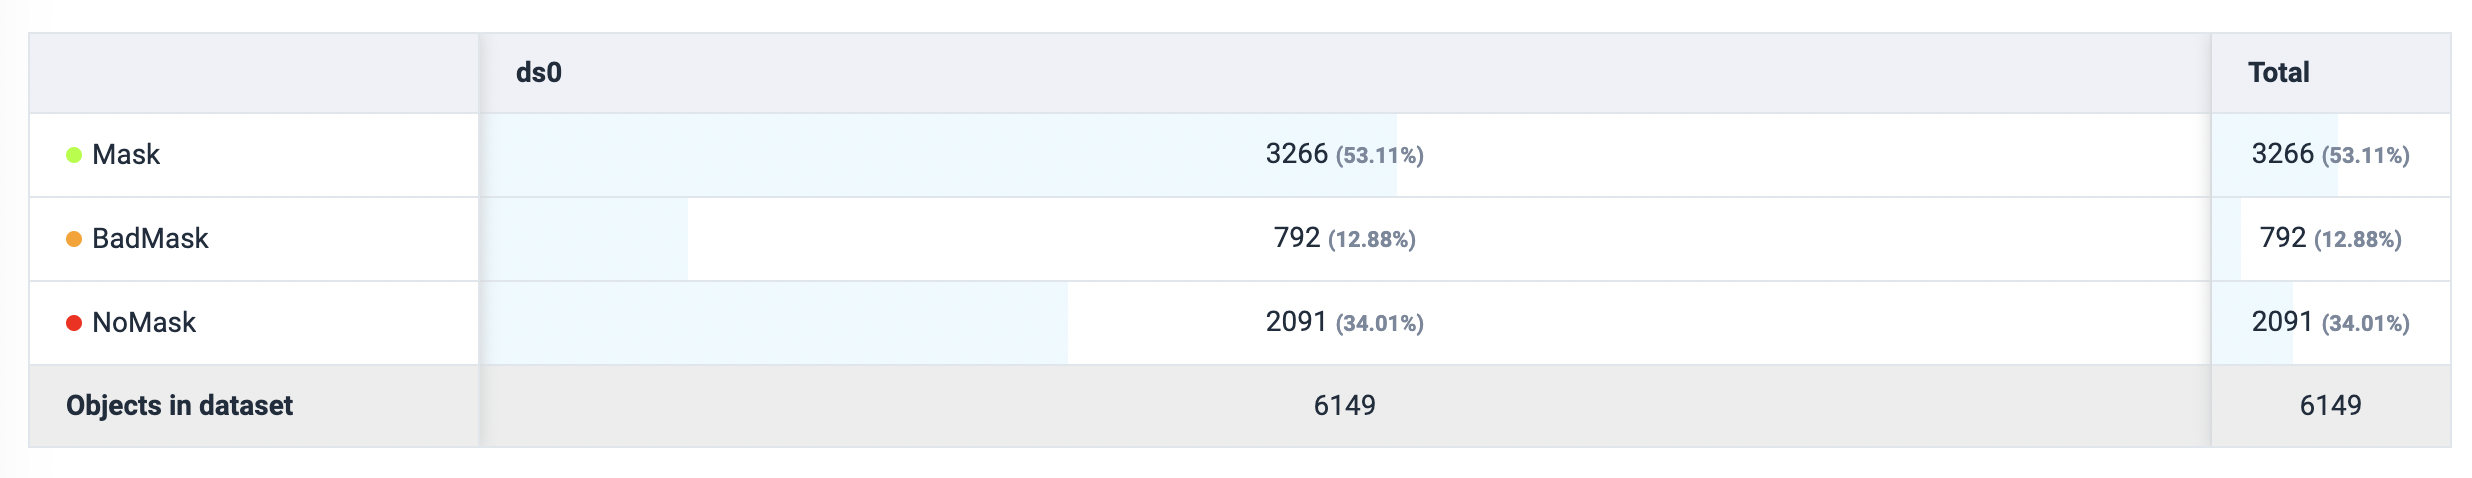

This is the repartition of the classes in the dataset we made ourselves, we can see that most of the classes are related to Mask and NoMask.
As we said earlier to push this project one step further we need to improve the dataset on several point: 


*   More data with the BadMask class
*   More diversity in ethnicity
*   More diveristy in the type of mask



Videos can be available if you follow the Notebook (make sure to make a proper detect with the best.pt we provide), or in the Drive.
But here are a few screenshots of our demo !
#**Don't hesitate to take a look at our github repo where you will find the demo and an extra feature: [FaceMaskRecognition Repo](https://github.com/goldentrex/FaceMaskRecognition)**
Indeed we explored a way to pute a virtual mask on people in a video. This feature can definitly be used for a data augmentation process take a look at this notebook:
https://github.com/goldentrex/FaceMaskRecognition/tree/main/VirtualMask

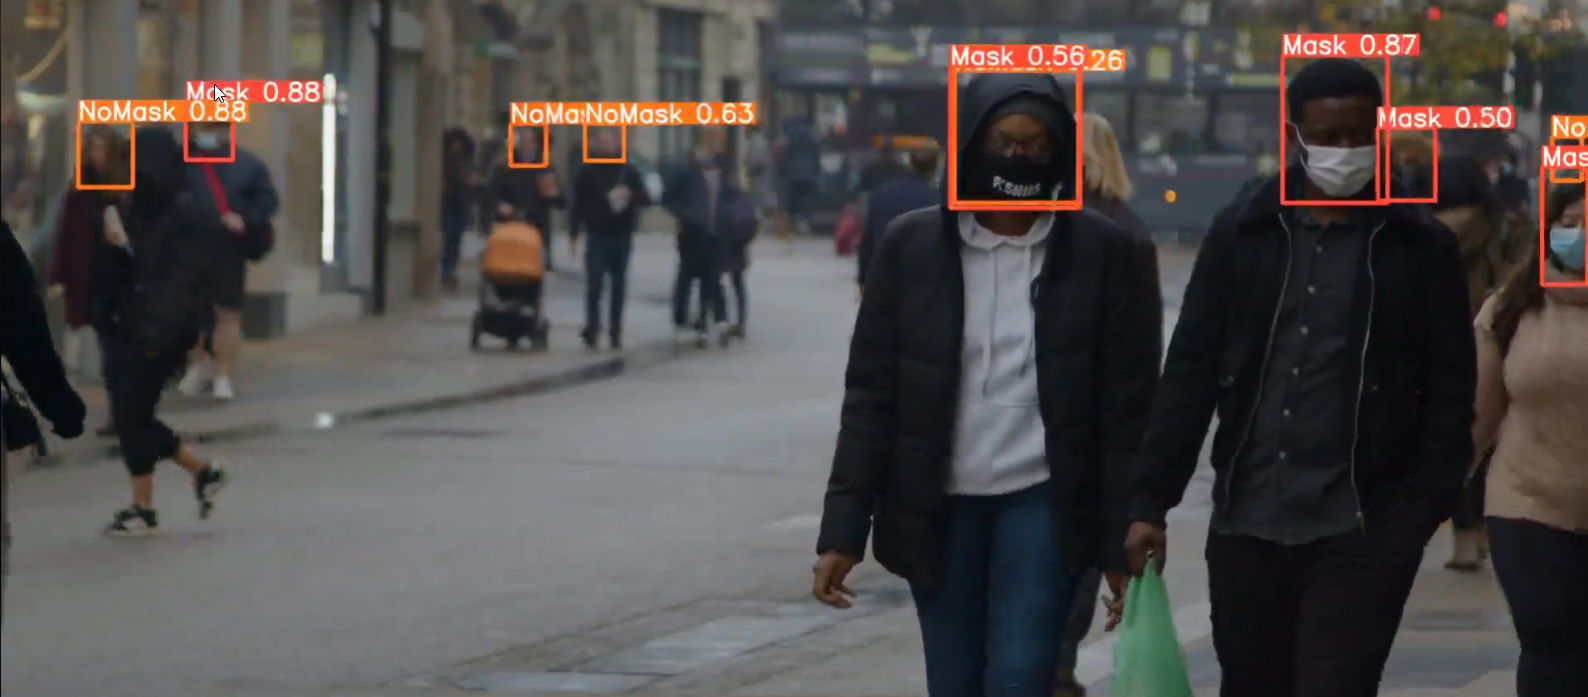

Thank you for following this Notebook.